##### Inicio

#### Carga de datos

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import sklearn
import logging
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

#  cargar algoritmos para aprendizaje supervisado
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

# importar fichero con utilidades propias
from commons import myfunctions as myfunc


CPU_COUNT: 8; NODE: amilcar22; sys.version: 3.10.12 (main, Jul  5 2023, 19:22:19) [GCC 11.2.0]
LOKY_MAX_CPU_COUNT: 6
OMP_NUM_THREADS: 2


#### Parámetros a utilizar en el entrenamiento.

Se indican los 3 algoritmos de *selección de características* (eval_selector_xxx) y los 3 algoritmos para la _clasificación_ (eval_clasifier_xxx)

En *param_distributions* se indicar los parámetros que utilizan los algoritmos en la función RandomSearchCV.

Esta celda tiene la etiqueta **parameters** que servirá para poder lanzar los entrenamientos con la utilidad **papermill** pasándole un fichero con los parámetros. Los nuevos parámetros se situarán tras esta celda para tener prevalencia.

In [2]:
#  Parametros para el entrenamiento

SEMILLA=        42
M_TIPO=         "mul_m"
M_SELECT=       "MI"
M_CLASIF=       "SVM"
R_FICHERO=      "resultados"
M_FICHERO=      "metricas"
PRE_DATA_FILE=  "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING=        "roc_auc_ovr" 
MAX_ITERS=      100

def mutual_info_classif_state(X, y):
    return mutual_info_classif(X, y, random_state=SEMILLA)

eval_selector_mi = "SelectKBest(score_func=mutual_info_classif_state)"
eval_selector_rf=  "SelectFromModel(estimator=RandomForestClassifier(random_state=SEMILLA), threshold=-np.inf)"
eval_selector_anova=  "SelectKBest(score_func=f_classif)"

eval_clasifier_svm= "SVC(probability=True, random_state=SEMILLA)"
eval_clasifier_rf= "RandomForestClassifier(random_state=SEMILLA)"
eval_clasifier_lr= "LogisticRegressionCV(random_state=SEMILLA)"

if M_TIPO.startswith("bin_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_mi
    eval_clasifier = eval_clasifier_svm

    SEMILLA = 6578
    M_SELECT = "MI"
    M_CLASIF = "SVM"
    param_distributions = {'selector__k': [1000], 
         'clasifier__kernel': ['rbf'], 'clasifier__gamma': [0.01], 'clasifier__C': [100]}
elif M_TIPO.startswith("bin_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [200], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

elif M_TIPO.startswith("mul_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
 
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [400], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

else:
    # M_TIPO.startswith("mul_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_anova
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 1860
    M_SELECT = "ANOVA"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__k': [1000], 
        'clasifier__solver': ['saga'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}



20231030T124845 : amilcar22 : INFO : Utilizando parámetros de mul_m


In [3]:
# Parameters
M_TIPO = "bin_m"
M_SELECT = "MI"
M_CLASIF = "LR_EN"
P_FICHERO = "param_0000_6390_bin_m_MI_LR_EN.yaml"
R_FICHERO = "resultados_6390"
M_FICHERO = "metricas_6390"
PRE_DATA_FILE = "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING = "roc_auc_ovr"
SEMILLA = 6390
MAX_ITERS = 500
eval_selector = "SelectKBest(score_func=mutual_info_classif_state)"
eval_clasifier = "LogisticRegressionCV(random_state=SEMILLA)"
param_distributions = {
    "selector__k": [1000],
    "clasifier__solver": ["saga"],
    "clasifier__penalty": ["elasticnet"],
    "clasifier__max_iter": [10000],
    "clasifier__l1_ratios": [[0.45]],
}


In [4]:
DATA_FILE = PRE_DATA_FILE + M_TIPO

# si viene "None" en el parámetro max_depth, se le quitan las comillas para que no sea entendido por el algoritmo como un texto
if "clasifier__max_depth" in param_distributions:
    param_distributions['clasifier__max_depth'] = [None if x == 'None' else x for x in param_distributions['clasifier__max_depth']]

Asignar los algoritmos que se utilizarán en la función RandomSearchCV

In [5]:
algor_selector=eval(eval_selector)
algor_clasifier=eval(eval_clasifier)

#### Comprobar el entorno y leer fichero de muestras

In [6]:
start_time = datetime.datetime.now()

myfunc.reset_vars()

myfunc.NOTEBK_FILENAME = myfunc.get_nb_name()

myfunc.check_enviroment(myfunc.DATA_DIR, myfunc.CFDNA_DIR, myfunc.GENCODE_DIR, myfunc.H5_DIR, myfunc.LOG_DIR, myfunc.CSV_DIR, myfunc.MODEL_DIR, myfunc.EXEC_DIR, myfunc.MET_DIR)

# Leer fichero con las muestras
df_t = myfunc.read_h5_to_df(DATA_FILE, myfunc.H5_DIR)
display(df_t.groupby("target").size())
print("Shape df:",df_t.shape)

# Separar caracteristicas/genes de las etiquetas/tipos de cáncer
X = df_t.iloc[:, :-1]  # Todas las columnas excepto la última
y = df_t.iloc[:, -1]  # La última columna contiene los identificadores de los tipos de cáncer

#  Crear el conjunto de datos de entrenamiento y de pruebas, y se fija la semilla para siempre coger el mismo juego de muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print("Shape X_train:",X_train.shape)
print("Shape X_test:",X_test.shape)


20231030T124845 : amilcar22 : INFO : Encontrada carpeta DATA_DIR=../tfm_git/datos
20231030T124845 : amilcar22 : INFO : Encontrada carpeta CFDNA_DIR=../tfm_git/datos/cfDNA_5hmC
20231030T124845 : amilcar22 : INFO : Encontrada carpeta GENCODE_DIR=../tfm_git/datos/gencode
20231030T124845 : amilcar22 : INFO : Encontrada carpeta H5_DIR=../tfm_git/datos/h5
20231030T124845 : amilcar22 : INFO : Encontrada carpeta LOG_DIR=../tfm_git/datos/logs
20231030T124845 : amilcar22 : INFO : Encontrada carpeta CSV_DIR=../tfm_git/datos/csv
20231030T124845 : amilcar22 : INFO : Encontrada carpeta MODEL_DIR=../tfm_git/ejecuciones/modelos
20231030T124845 : amilcar22 : INFO : Encontrada carpeta EXEC_DIR=../tfm_git/ejecuciones
20231030T124845 : amilcar22 : INFO : Encontrada carpeta MET_DIR=../tfm_git/ejecuciones/metricas
20231030T124845 : amilcar22 : INFO : Inicio leer fichero h5 ../tfm_git/datos/h5/rows_transpose_norm_by_gene_id_with_target_num_bin_m.h5
20231030T124845 : amilcar22 : INFO : Leyendo clave /df


20231030T124846 : amilcar22 : INFO : Tamaño (720, 18876)
20231030T124846 : amilcar22 : INFO : Fin leer fichero h5 ../tfm_git/datos/h5/rows_transpose_norm_by_gene_id_with_target_num_bin_m.h5


target
0    360
1    360
dtype: int64

Shape df: (720, 18876)
Shape X_train: (576, 18875)
Shape X_test: (144, 18875)


#### Selección de características y clasificación.

In [7]:
myfunc.verbose("Iniciando entrenamiento")

kf = KFold(n_splits=5, shuffle=True, random_state=SEMILLA)

# Crear el pipeline para el flujo de tareas
tasks_pipeline = Pipeline([
    ('selector', algor_selector),
    ('clasifier', algor_clasifier)
])

# MAX_ITERS puede limitar el número de iteraciones si son excesivas para las combinaciones de parámetros buscando un óptimo local, 
# sino funcionaría como GridSearchCV al revisar todas las cominaciones de los parámetros
num_iteraciones = 1
num_iteraciones = num_iteraciones * np.prod([len(elemento1) for _, elemento1 in param_distributions.items()])
max_iteraciones = num_iteraciones if num_iteraciones <= MAX_ITERS else MAX_ITERS
print("num_iter:",num_iteraciones,", max_iter:",max_iteraciones)

random_search = RandomizedSearchCV(
    tasks_pipeline, 
    param_distributions, 
    n_iter=max_iteraciones,
    scoring=SCORING,
    cv=kf,
    verbose=3, 
    random_state=SEMILLA, 
    n_jobs=-1
    )

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Ver los mejores hiperparámetros encontrados
print(f'Mejores Hiperparámetros: {random_search.best_params_}')
print(f'Mejor Puntuación: {random_search.best_score_:.4f}')

# Nos quedamos con el mejor modelo para ver las métricas
mejor_modelo = random_search.best_estimator_

myfunc.verbose("Fin entrenamiento")

20231030T124846 : amilcar22 : INFO : Iniciando entrenamiento
num_iter: 1 , max_iter: 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 3/5] END clasifier__l1_ratios=[0.45], clasifier__max_iter=10000, clasifier__penalty=elasticnet, clasifier__solver=saga, selector__k=1000;, score=0.852 total time= 5.0min


[CV 1/5] END clasifier__l1_ratios=[0.45], clasifier__max_iter=10000, clasifier__penalty=elasticnet, clasifier__solver=saga, selector__k=1000;, score=0.790 total time= 5.5min


[CV 2/5] END clasifier__l1_ratios=[0.45], clasifier__max_iter=10000, clasifier__penalty=elasticnet, clasifier__solver=saga, selector__k=1000;, score=0.820 total time= 5.6min


[CV 5/5] END clasifier__l1_ratios=[0.45], clasifier__max_iter=10000, clasifier__penalty=elasticnet, clasifier__solver=saga, selector__k=1000;, score=0.861 total time= 7.0min


[CV 4/5] END clasifier__l1_ratios=[0.45], clasifier__max_iter=10000, clasifier__penalty=elasticnet, clasifier__solver=saga, selector__k=1000;, score=0.902 total time= 7.1min


Mejores Hiperparámetros: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'elasticnet', 'clasifier__max_iter': 10000, 'clasifier__l1_ratios': [0.45]}
Mejor Puntuación: 0.8449
20231030T130135 : amilcar22 : INFO : Fin entrenamiento


#### Guardar modelo

In [8]:
fichero_modelo = str.replace("modelo_"+str(SEMILLA).zfill(4)+"_"+M_TIPO+"_"+M_SELECT+"_"+M_CLASIF+".pkl", " ", "_")

myfunc.save_modelo(mejor_modelo, myfunc.MODEL_DIR, fichero_modelo)

20231030T130135 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/modelos/modelo_6390_bin_m_MI_LR_EN.pkl
20231030T130135 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/modelos/modelo_6390_bin_m_MI_LR_EN.pkl


#### Ver resultados del las iteraciones hechas por RandomSearchCV

In [9]:
myfunc.ver_resultados_search(random_search)

20231030T130135 : amilcar22 : INFO : Inicio ver resultados
Mejores Hiperparámetros: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'elasticnet', 'clasifier__max_iter': 10000, 'clasifier__l1_ratios': [0.45]}
Mejores puntuaciones: 0.8449 | Params: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'elasticnet', 'clasifier__max_iter': 10000, 'clasifier__l1_ratios': [0.45]}
Media de las puntuaciones: 0.8449 | Params: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'elasticnet', 'clasifier__max_iter': 10000, 'clasifier__l1_ratios': [0.45]}
20231030T130135 : amilcar22 : INFO : Fin resultados


#### Ver métricas del mejor modelo

20231030T130135 : amilcar22 : INFO : Inicio ver métricas


              precision    recall  f1-score   support

           0       0.82      0.84      0.83        82
           1       0.78      0.76      0.77        62

    accuracy                           0.81       144
   macro avg       0.80      0.80      0.80       144
weighted avg       0.81      0.81      0.81       144



   Exactitud: 0.8056
   Precisión: 0.8024
Sensibilidad: 0.7998
    F1-score: 0.8009
     AUC ROC: 0.9162


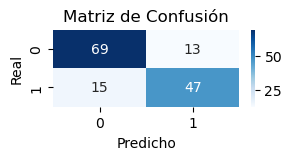

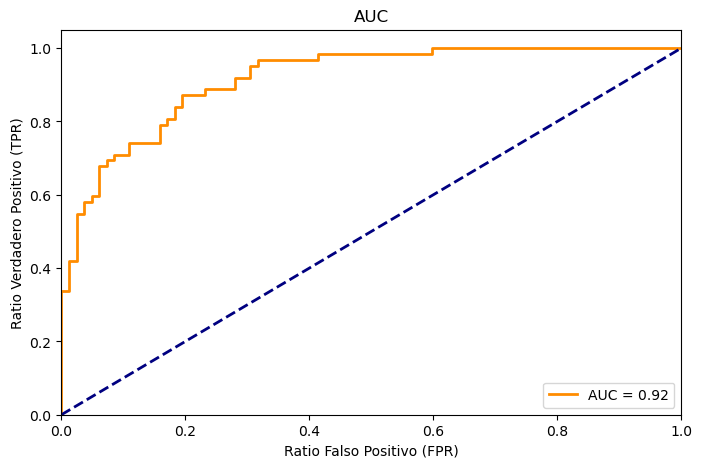

20231030T130136 : amilcar22 : INFO : Fin ver métricas


In [10]:
if M_TIPO.startswith("bin"):
    myfunc.ver_metricas(mejor_modelo, X_test, y_test)
else:
    myfunc.ver_metricas_multi(mejor_modelo, X_test, y_test)


#### Finalización del notebook

In [11]:
end_time = datetime.datetime.now()
total_time = end_time - start_time
myfunc.verbose(f"Notebook ha tardado {total_time.seconds} seconds")

20231030T130136 : amilcar22 : INFO : Notebook ha tardado 770 seconds


#### Guardar métricas

In [12]:
if M_TIPO.startswith("bin"):
    myfunc.save_metricas_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)
else:
    myfunc.save_metricas_multi_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)

df1=myfunc.read_metricas_to_df(myfunc.MET_DIR,M_FICHERO)

display(df1.sort_values("datetime", ascending=False)[:3])


20231030T130136 : amilcar22 : INFO : Inicio guardar métricas
20231030T130136 : amilcar22 : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T130136 : amilcar22 : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T130136 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T130136 : amilcar22 : INFO : Fichero borrado ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T130136 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T130136 : amilcar22 : INFO : Fin guardar métricas
20231030T130136 : amilcar22 : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv
20231030T130136 : amilcar22 : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_6390.csv


,tipo,select,clasific,semilla,accuracy,precision,recall,f1_score,roc_auc,hostname,total_time_sec,datetime,fichero_modelo,params,shape,features
0,bin_m,MI,LR_EN,6390,0.805556,0.802381,0.799764,0.800909,0.916208,amilcar22,770,2023-10-30 13:01:36.409442,modelo_6390_bin_m_MI_LR_EN.pkl,"{'selector__k': 1000, 'clasifier__solver': 'sa...","X_test:(144, 18875)","['ENSG00000002330.14', 'ENSG00000002933.9', 'E..."
0,bin_m,ANOVA,SVM,6390,0.826389,0.822751,0.823958,0.823313,0.910307,amilcar22,3,2023-10-30 12:48:39.863020,modelo_6390_bin_m_ANOVA_SVM.pkl,"{'selector__k': 500, 'clasifier__kernel': 'rbf...","X_test:(144, 18875)","['ENSG00000000971.17', 'ENSG00000001626.18', '..."
0,bin_m,ANOVA,RF,6390,0.819444,0.815893,0.815893,0.815893,0.894768,amilcar22,10,2023-10-30 12:48:30.186949,modelo_6390_bin_m_ANOVA_RF.pkl,"{'selector__k': 500, 'clasifier__n_estimators'...","X_test:(144, 18875)","['ENSG00000000971.17', 'ENSG00000001626.18', '..."


#### Guardar resultados

In [13]:
fichero_resultados=R_FICHERO+"_"+M_TIPO+"-"+M_SELECT+"-"+M_CLASIF+".csv"
myfunc.save_resultados_to_csv(M_TIPO, M_SELECT, M_CLASIF,  random_search, myfunc.MET_DIR, fichero_resultados)


20231030T130136 : amilcar22 : INFO : Inicio guardar resultados
20231030T130136 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/resultados_6390_bin_m-MI-LR_EN.csv
20231030T130136 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/resultados_6390_bin_m-MI-LR_EN.csv
20231030T130136 : amilcar22 : INFO : Fin guardar resultados
